## 1.Data processing

**library**

In [2]:
import zipfile
import numpy as np
import os
import scipy.io
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
%matplotlib inline
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

In [67]:
import os
import zipfile
import scipy.io

# Define the path to the SEED.zip file and extraction path
zip_path = "/Users/peinuoyi/595/SEED.zip" 
extract_path = "./seed_data"

# Step 1: Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to {extract_path}")

# Step 2: Define the directory where .mat files are stored
data_dir = os.path.join(extract_path, "SEED", "ExtractedFeatures")

# Confirm that the file has been extracted correctly
print("Files found:")
for root, dirs, files in os.walk(data_dir):
    for file in files:
        print(os.path.join(root, file))

print(f"Searching for .mat files in: {data_dir}")
print(f"Files found: {[f for f in os.listdir(data_dir) if f.endswith('.mat')]}")

# Step 3: Example file to inspect
file_path = os.path.join(data_dir, "13_20140603.mat")

# Load the file
mat_data = scipy.io.loadmat(file_path)

# Print keys to verify the structure
print("Keys in the .mat file:", mat_data.keys())

# Check the structure of the 'de_movingAve' keys
for key in mat_data.keys():
    if "de_movingAve" in key:
        print(f"{key} shape: {mat_data[key].shape}")


Files extracted to ./seed_data
Files found:
./seed_data/SEED/ExtractedFeatures/13_20140603.mat
./seed_data/SEED/ExtractedFeatures/2_20140419.mat
./seed_data/SEED/ExtractedFeatures/11_20140618.mat
./seed_data/SEED/ExtractedFeatures/11_20140630.mat
./seed_data/SEED/ExtractedFeatures/15_20131016.mat
./seed_data/SEED/ExtractedFeatures/12_20131201.mat
./seed_data/SEED/ExtractedFeatures/11_20140625.mat
./seed_data/SEED/ExtractedFeatures/4_20140621.mat
./seed_data/SEED/ExtractedFeatures/5_20140418.mat
./seed_data/SEED/ExtractedFeatures/6_20131016.mat
./seed_data/SEED/ExtractedFeatures/8_20140521.mat
./seed_data/SEED/ExtractedFeatures/14_20140615.mat
./seed_data/SEED/ExtractedFeatures/14_20140601.mat
./seed_data/SEED/ExtractedFeatures/12_20131207.mat
./seed_data/SEED/ExtractedFeatures/label.mat
./seed_data/SEED/ExtractedFeatures/13_20140610.mat
./seed_data/SEED/ExtractedFeatures/15_20130709.mat
./seed_data/SEED/ExtractedFeatures/7_20131106.mat
./seed_data/SEED/ExtractedFeatures/9_20140627.mat


In [5]:
import scipy.io
import numpy as np
# Path to the label.mat file
label_path = "./seed_data/SEED/ExtractedFeatures/label.mat"

# Load the .mat file
label_data = scipy.io.loadmat(label_path)

# Print the keys to see what is inside the file
print("Keys in label.mat file:", label_data.keys())

# Access and print the 'label' data
if 'label' in label_data:
    labels = label_data['label']
    print("Shape of label data:", labels.shape)
    print("Labels:", labels.ravel())  # Flatten the array to see all labels
else:
    print("No 'label' key found in the file!")

# Original labels
labels = np.array([1, 0, -1, -1, 0, 1, -1, 0, 1, 1, 0, -1, 0, 1, -1])

# Replace -1 with 2 (to represent "Sad")
labels_corrected = np.where(labels == -1, 2, labels)

print("Corrected Labels:", labels_corrected)


Keys in label.mat file: dict_keys(['__header__', '__version__', '__globals__', 'label'])
Shape of label data: (1, 15)
Labels: [ 1  0 -1 -1  0  1 -1  0  1  1  0 -1  0  1 -1]
Corrected Labels: [1 0 2 2 0 1 2 0 1 1 0 2 0 1 2]


In [7]:
def load_seed_emotion_features(data_dir):
    """
    Load emotion-related features and labels from the SEED dataset
    return: EEG data (3D array) and labels
    """
    eeg_data_list = []
    labels_list = []

    # Load labels
    label_path = os.path.join(data_dir, 'label.mat')
    if os.path.exists(label_path):
        labels = scipy.io.loadmat(label_path)['label'].ravel()
        print(f"Shape of loaded labels: {labels.shape}")
    else:
        raise FileNotFoundError("The file 'label.mat' was not found in the directory.")

    # List all .mat files (excluding 'label.mat')
    mat_files = [f for f in os.listdir(data_dir) if f.endswith('.mat') and f != 'label.mat']
    print(f"Number of .mat files: {len(mat_files)}")

    # Iterate through .mat files and load emotion-related features
    for idx, file in enumerate(mat_files):
        file_path = os.path.join(data_dir, file)
        mat_data = scipy.io.loadmat(file_path)
        
        # Extract 'de_movingAve' features
        for i in range(1, 16):
            key = f'de_movingAve{i}'
            if key in mat_data:
                eeg_data = mat_data[key]  # Shape: (channels, time_steps)
                print(f"Loaded {key} from {file}, shape: {eeg_data.shape}")
                eeg_data_list.append(eeg_data)
                labels_list.append(labels[idx % len(labels)])

    # Align all data to the same time_steps
    min_time_steps = min(eeg.shape[1] for eeg in eeg_data_list)
    print(f"Minimum time steps: {min_time_steps}")
    
    # Trim all EEG data to the minimum time_steps
    eeg_data_list = [eeg[:, :min_time_steps] for eeg in eeg_data_list]

    # Combine EEG data and labels
    if eeg_data_list and labels_list:
        eeg_data = np.stack(eeg_data_list, axis=0)  # Shape: (samples, channels, time_steps)
        labels = np.array(labels_list)  # Shape: (samples,)
        return eeg_data, labels
    else:
        raise ValueError("EEG data or labels are invalid.")

# Example usage
data_dir = "./seed_data/SEED/ExtractedFeatures"
X, y = load_seed_emotion_features(data_dir)
print(f"EEG data shape: {X.shape}")
print(f"Labels shape: {y.shape}")


Shape of loaded labels: (15,)
Number of .mat files: 45
Loaded de_movingAve1 from 13_20140603.mat, shape: (62, 235, 5)
Loaded de_movingAve2 from 13_20140603.mat, shape: (62, 233, 5)
Loaded de_movingAve3 from 13_20140603.mat, shape: (62, 206, 5)
Loaded de_movingAve4 from 13_20140603.mat, shape: (62, 238, 5)
Loaded de_movingAve5 from 13_20140603.mat, shape: (62, 185, 5)
Loaded de_movingAve6 from 13_20140603.mat, shape: (62, 195, 5)
Loaded de_movingAve7 from 13_20140603.mat, shape: (62, 237, 5)
Loaded de_movingAve8 from 13_20140603.mat, shape: (62, 216, 5)
Loaded de_movingAve9 from 13_20140603.mat, shape: (62, 265, 5)
Loaded de_movingAve10 from 13_20140603.mat, shape: (62, 237, 5)
Loaded de_movingAve11 from 13_20140603.mat, shape: (62, 235, 5)
Loaded de_movingAve12 from 13_20140603.mat, shape: (62, 233, 5)
Loaded de_movingAve13 from 13_20140603.mat, shape: (62, 235, 5)
Loaded de_movingAve14 from 13_20140603.mat, shape: (62, 238, 5)
Loaded de_movingAve15 from 13_20140603.mat, shape: (62, 20

In [8]:
# Inspect a sample EEG waveform
sample_index = 0
channel_index = 0

eeg_waveform = X[sample_index, channel_index, :]
print("EEG Signal Shape:", eeg_waveform.shape)
print("First 10 values of the EEG waveform:", eeg_waveform[:10])
print("Range of EEG values:", eeg_waveform.min(), "to", eeg_waveform.max())


EEG Signal Shape: (185, 5)
First 10 values of the EEG waveform: [[29.19565752 20.77299277 19.26985158 20.29656448 20.36673237]
 [25.18427376 22.72336772 21.9650734  20.31566777 20.43292639]
 [25.654861   22.25533621 21.46587977 20.87700507 20.15857214]
 [26.36807779 20.88767781 19.0341507  20.57483304 19.51448145]
 [26.26963063 21.27632728 20.46401281 20.58799625 20.2226291 ]
 [25.94005161 21.30331724 21.04653367 20.71777134 20.20790768]
 [26.10246898 20.85842954 21.21032465 20.59165761 20.06429704]
 [25.80726336 21.01686442 21.07452245 20.54762846 20.01453605]
 [24.98796088 21.01072207 21.44487813 20.45349529 20.22366804]
 [24.43008298 21.28372288 21.42952847 20.15085366 19.99774132]]
Range of EEG values: 18.15242440218463 to 29.263189614246425


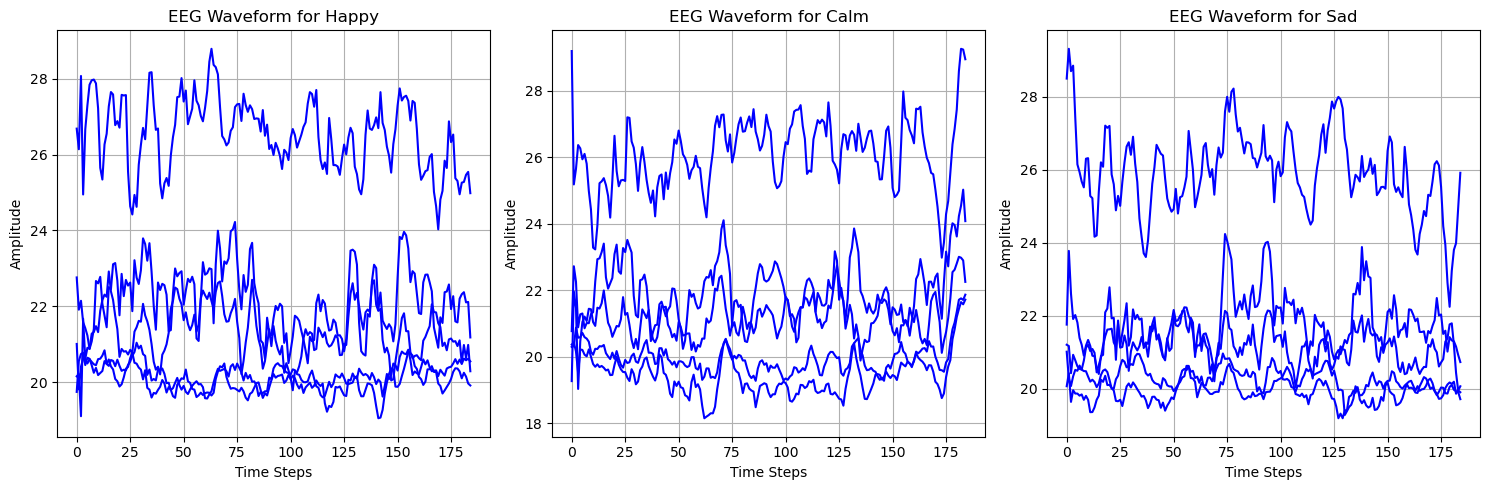

In [13]:
import matplotlib.pyplot as plt

def plot_emotion_waveforms(eeg_data, labels, emotion_labels):
    """
    Plot EEG waveforms for samples 3 different emotions.
    Corrected Labels: [1 0 2 2 0 1 2 0 1 1 0 2 0 1 2]
    0-Calm; 1-happy; 2-sad
    """
    plt.figure(figsize=(15, 5))

    for emotion_class in range(3):
        indices = np.where(labels == emotion_class)[0]
        if len(indices) == 0:
            print(f"No data found for class {emotion_class} ({emotion_labels[emotion_class]})")
            continue

        emotion_index = indices[0]  
        eeg_waveform = eeg_data[emotion_index, 0, :] 

        plt.subplot(1, 3, emotion_class + 1)
        plt.plot(eeg_waveform, color='b', linewidth=1.5)
        plt.title(f"EEG Waveform for {emotion_labels[emotion_class]}")
        plt.xlabel("Time Steps")
        plt.ylabel("Amplitude")
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Emotion labels
emotion_labels = ["Happy", "Calm", "Sad"]

# Call the function to plot EEG waveforms
plot_emotion_waveforms(X, labels_corrected, emotion_labels)


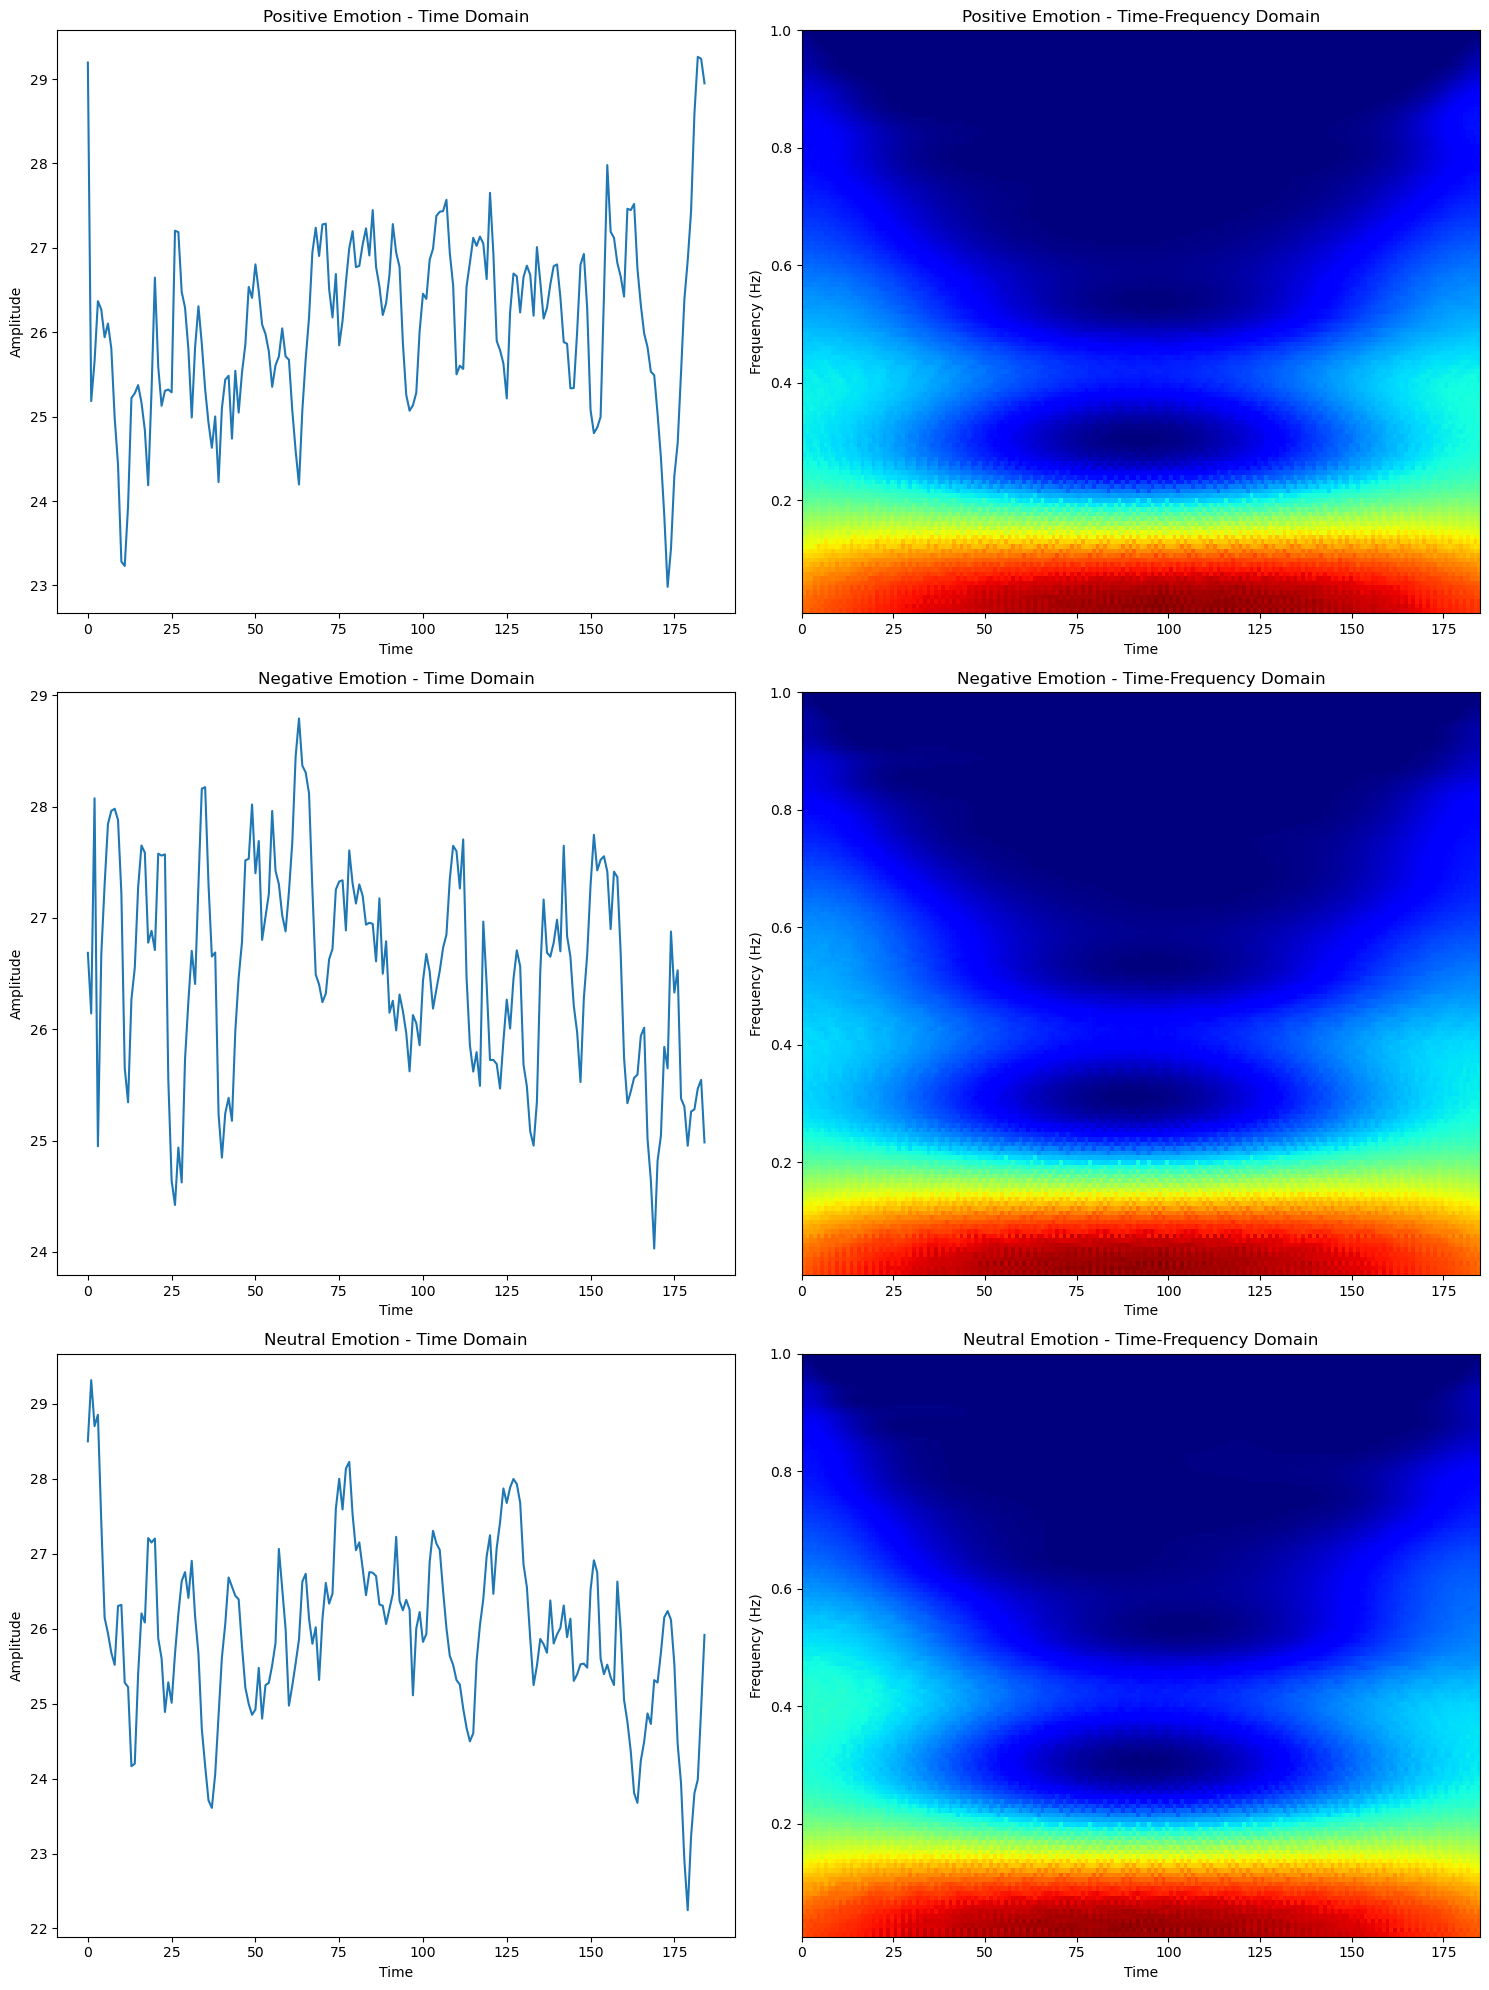

In [15]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

# Select 3 EEG samples representing different emotions
positive_sample = X[0, 0, :, 0]  # Sample representing Positive emotion
negative_sample = X[1, 0, :, 0]  # Sample representing Negative emotion
neutral_sample = X[2, 0, :, 0]   # Sample representing Neutral emotion

# Define Continuous Wavelet Transform (CWT) parameters
wavelet = 'cmor1.5-1.0'  # Complex Morlet wavelet for time-frequency analysis
scales = np.arange(1, 128)  # Scale range for the wavelet transform

# Perform Continuous Wavelet Transform
def cwt_transform(signal):
    """
    Perform Continuous Wavelet Transform (CWT) on the input signal.
    :param signal: 1D array representing the EEG signal
    :return: Power spectrum (magnitude squared of coefficients)
    """
    coef, freqs = pywt.cwt(signal, scales, wavelet)
    return np.abs(coef)**2, freqs

# Apply CWT to the three EEG samples
positive_tf, freqs = cwt_transform(positive_sample)
negative_tf, freqs = cwt_transform(negative_sample)
neutral_tf, freqs = cwt_transform(neutral_sample)

# Plot time-domain and time-frequency domain representations
fig, axs = plt.subplots(3, 2, figsize=(15, 20))

# Positive Emotion
axs[0, 0].plot(positive_sample)
axs[0, 0].set_title('Positive Emotion - Time Domain')
axs[0, 1].imshow(positive_tf, aspect='auto', cmap='jet', 
                 extent=[0, len(positive_sample), freqs[-1], freqs[0]])
axs[0, 1].set_title('Positive Emotion - Time-Frequency Domain')

# Negative Emotion
axs[1, 0].plot(negative_sample)
axs[1, 0].set_title('Negative Emotion - Time Domain')
axs[1, 1].imshow(negative_tf, aspect='auto', cmap='jet', 
                 extent=[0, len(negative_sample), freqs[-1], freqs[0]])
axs[1, 1].set_title('Negative Emotion - Time-Frequency Domain')

# Neutral Emotion
axs[2, 0].plot(neutral_sample)
axs[2, 0].set_title('Neutral Emotion - Time Domain')
axs[2, 1].imshow(neutral_tf, aspect='auto', cmap='jet', 
                 extent=[0, len(neutral_sample), freqs[-1], freqs[0]])
axs[2, 1].set_title('Neutral Emotion - Time-Frequency Domain')

# Set labels for axes
for ax in axs[:, 0]:  # Time-domain plots
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')

for ax in axs[:, 1]:  # Time-frequency domain plots
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency (Hz)')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


In [40]:
# split dataste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Convert labels to categorical format
y_train_3 = to_categorical(y_train, num_classes=3) 
y_test_3 = to_categorical(y_test, num_classes=3)

# check
print("Shape of X_train_scaled:", X_train_scaled.shape)
print("Shape of y_train_3:", y_train_3.shape)


Shape of X_train_scaled: (540, 62, 185, 5)
Shape of y_train_3: (540, 3)


Cluster Centers: [[-134.19333091  -21.22910918]
 [ 132.16269919   12.75363023]
 [ -32.39123648    2.90708194]]


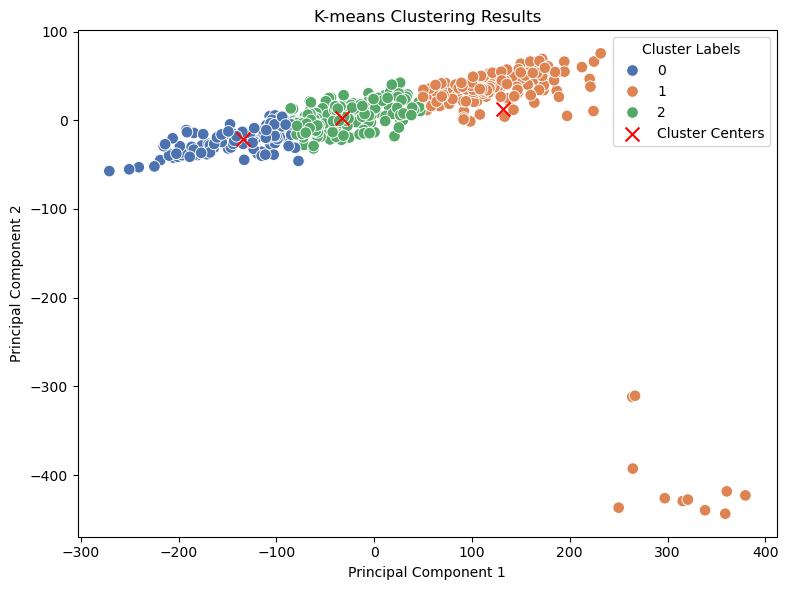

In [24]:
# clustering
# Reduce data dimensionality
X_train_flat = X_train_scaled.reshape(X_train_scaled.shape[0], -1)
scaler = StandardScaler()
X_train_flat_scaled = scaler.fit_transform(X_train_flat)

pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train_flat_scaled)

# K-means 
kmeans = KMeans(n_clusters=3, random_state=42)  
y_kmeans = kmeans.fit_predict(X_train_2d)  

# View cluster centers
centers = kmeans.cluster_centers_
print("Cluster Centers:", centers)

# Visualizing clustering results
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_train_2d[:, 0], y=X_train_2d[:, 1], hue=y_kmeans, palette="deep", s=70)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=100, marker='x', label="Cluster Centers")
plt.title("K-means Clustering Results")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster Labels")

plt.tight_layout()
plt.show()



## 2. Model Design

**2.1 SVM**

In [21]:
y_train_int = np.argmax(y_train_3, axis=1)
y_test_int = np.argmax(y_test_3, axis=1)

# Flatten data for SVM
X_train_flat = X_train_scaled.reshape(X_train_scaled.shape[0], -1)
X_test_flat = X_test_scaled.reshape(X_test_scaled.shape[0], -1)


In [23]:
# Create and Train SVM classifier
svm_model = SVC(
    kernel='rbf', 
    C=1.0, 
    gamma='scale', 
    random_state=42
)

svm_model.fit(X_train_flat, y_train_int)

# Predict and evaluate
y_pred = svm_model.predict(X_test_flat)


In [27]:
from sklearn.metrics import classification_report

# Evaluate and print classification report with zero_division parameter
print("Classification Report of SVM:\n", classification_report(y_test_int, y_pred, zero_division=0))


Classification Report of SVM:
               precision    recall  f1-score   support

           0       0.97      0.91      0.94        35
           1       0.90      0.94      0.92        48
           2       0.94      0.94      0.94        52

    accuracy                           0.93       135
   macro avg       0.94      0.93      0.93       135
weighted avg       0.93      0.93      0.93       135



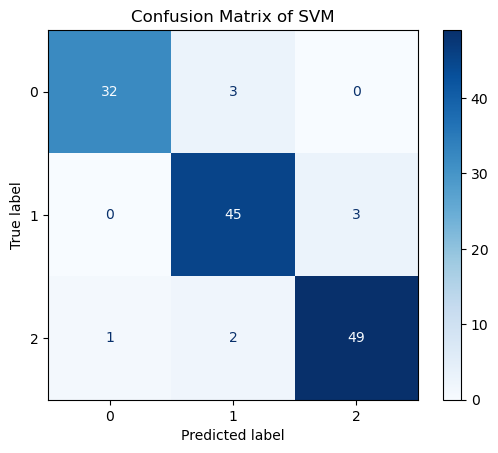

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# confusion matrix
conf_matrix = confusion_matrix(y_test_int, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1, 2])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix of SVM")
plt.show()


X_train_flat shape: (540, 57350)
X_test_flat_fixed shape: (135, 57350)


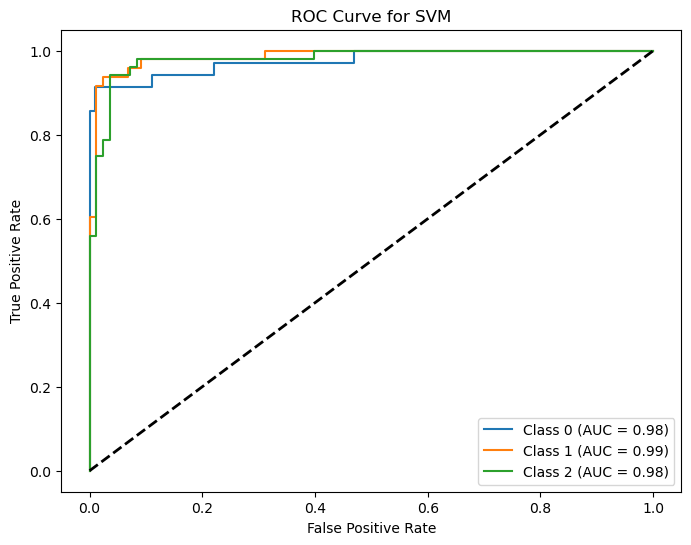

In [109]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Flatten X_test to match SVM input
X_test_flat_fixed = X_test_scaled.reshape(X_test_scaled.shape[0], -1)

# Verify dimensions
print("X_train_flat shape:", X_train_flat.shape)
print("X_test_flat_fixed shape:", X_test_flat_fixed.shape)

# Predict decision scores for ROC curve
decision_scores = svm_model.decision_function(X_test_flat_fixed)

# Compute and plot ROC curves for each class
plt.figure(figsize=(8, 6))
for i in range(3):  # Loop through the 3 classes
    fpr, tpr, _ = roc_curve(y_test_3[:, i], decision_scores[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {auc_score:.2f})")

# Plot the diagonal line for reference
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title("ROC Curve for SVM")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


**2.2 LSTM**

In [51]:
from sklearn.decomposition import PCA

X_train_flat = X_train_scaled.reshape(X_train_scaled.shape[0], -1)
X_test_flat = X_test_scaled.reshape(X_test_scaled.shape[0], -1)

pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)

# Reshape back to 3D for LSTM
X_train_reshaped = X_train_pca.reshape(X_train_pca.shape[0], -1, 50)
X_test_reshaped = X_test_pca.reshape(X_test_pca.shape[0], -1, 50)


print("Reshaped X_train shape:", X_train_reshaped.shape) 
print("Reshaped X_test shape:", X_test_reshaped.shape)    
print("Shape of y_train_3:", y_train_3.shape)            
print("Shape of y_test_3:", y_test_3.shape)

Reshaped X_train shape: (540, 1, 50)
Reshaped X_test shape: (135, 1, 50)
Shape of y_train_3: (540, 3)
Shape of y_test_3: (135, 3)


In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Build LSTM model and Add l2 to solve overfitting
lstm_model = Sequential([
    LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(64, return_sequences=False, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),

    Dense(3, activation='softmax')
])

# Compile model
lstm_model.compile(optimizer=Adam(learning_rate=0.001),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)


history = lstm_model.fit(
    X_train_reshaped, y_train_3,  
    validation_data=(X_test_reshaped, y_test_3),  
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3590 - loss: 1.7927 - val_accuracy: 0.5185 - val_loss: 1.3555
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5256 - loss: 1.3469 - val_accuracy: 0.6889 - val_loss: 1.3152
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6311 - loss: 1.0977 - val_accuracy: 0.7704 - val_loss: 1.2708
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6308 - loss: 1.0042 - val_accuracy: 0.8222 - val_loss: 1.2168
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7467 - loss: 0.8478 - val_accuracy: 0.8741 - val_loss: 1.1619
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7971 - loss: 0.7393 - val_accuracy: 0.9111 - val_loss: 1.0986
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8244 - loss: 0.6694 - val_accuracy: 0.9333 - val_loss: 1.0195
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8515 - loss: 0.6044 - val_accuracy: 0.9333 - val_loss

In [55]:
print("Shape of X_test_reshaped:", X_test_reshaped.shape)


Shape of X_test_reshaped: (135, 1, 50)


In [115]:
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Predict class probabilities and convert to class labels
y_pred_prob = lstm_model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred_prob, axis=1) 
y_true_classes = np.argmax(y_test_3, axis=1)     

# Print Classification Report
print("Classification Report of LSTM:")
print(classification_report(y_true_classes, y_pred_classes, target_names=["Class 0", "Class 1", "Class 2"]))

# Calculate and print Accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Overall Accuracy of LSTM: {accuracy:.2f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Classification Report of LSTM:
              precision    recall  f1-score   support

     Class 0       0.92      0.97      0.94        35
     Class 1       0.98      0.96      0.97        48
     Class 2       1.00      0.98      0.99        52

    accuracy                           0.97       135
   macro avg       0.97      0.97      0.97       135
weighted avg       0.97      0.97      0.97       135

Overall Accuracy of LSTM: 0.97


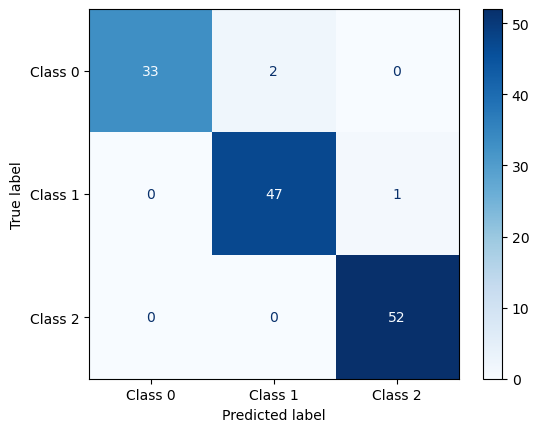

In [374]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1", "Class 2"])
disp.plot(cmap="Blues")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


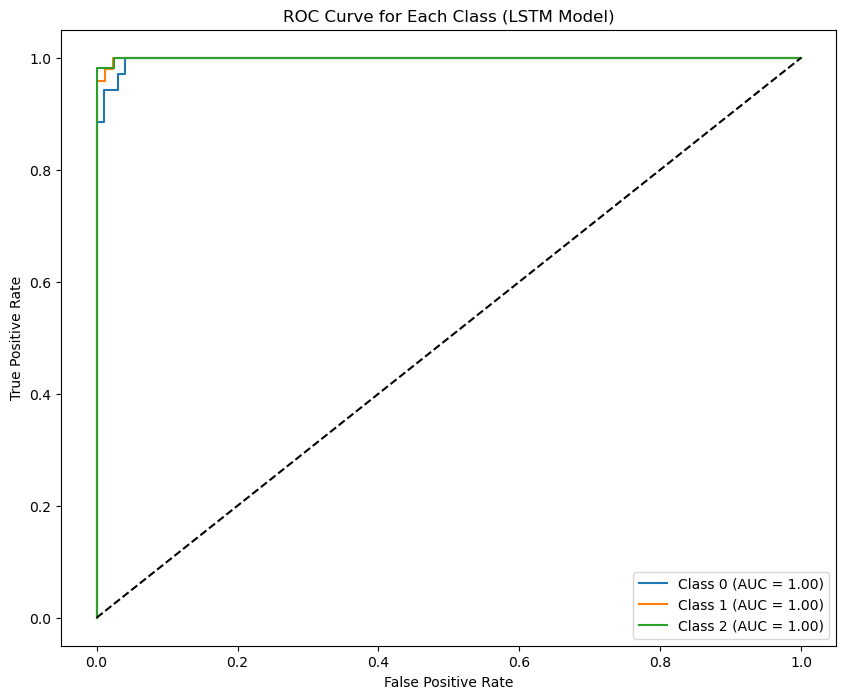

In [59]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the true labels (one-hot encoded)
y_true_binary = label_binarize(y_true_classes, classes=[0, 1, 2])  # Shape: (samples, n_classes)
n_classes = y_true_binary.shape[1]

# Predicted probabilities
y_pred_prob = lstm_model.predict(X_test_reshaped)

# Initialize plot
plt.figure(figsize=(10, 8))

# Plot ROC curve for each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_binary[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

# Plot reference line (random guessing)
plt.plot([0, 1], [0, 1], 'k--')

# Add labels and legend
plt.title("ROC Curve for Each Class (LSTM Model)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


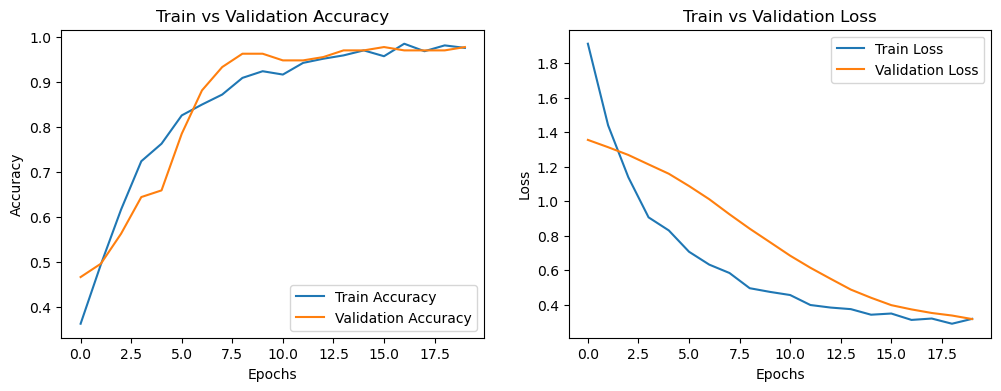

In [380]:
# Check for overfitting
# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Train vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


**2.3 Decision Tree**

In [77]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

# Reshape the data for Decision Tree (flatten)
X_train_flat = X_train_scaled.reshape(X_train_scaled.shape[0], -1)
X_test_flat = X_test_scaled.reshape(X_test_scaled.shape[0], -1)
y_train_flat = np.argmax(y_train_3, axis=1)  
y_test_flat = np.argmax(y_test_3, axis=1)

# Train Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_flat, y_train_flat)


DecisionTreeClassifier(random_state=42)

In [72]:
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")
print(f"y_train_3 shape: {y_train_3.shape}")
print(f"y_test_3 shape: {y_test_3.shape}")
print("Unique labels in y_train:", np.unique(np.argmax(y_train_3, axis=1)))
print("Unique labels in y_test:", np.unique(np.argmax(y_test_3, axis=1)))

X_train_scaled shape: (540, 62, 185, 5)
X_test_scaled shape: (135, 62, 185, 5)
y_train_3 shape: (540, 3)
y_test_3 shape: (135, 3)
Unique labels in y_train: [0 1 2]
Unique labels in y_test: [0 1 2]


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}
Classification Report for Optimized Decision Tree:
              precision    recall  f1-score   support

           0       0.64      0.91      0.75        35
           1       0.86      0.62      0.72        48
           2       0.80      0.77      0.78        52

    accuracy                           0.76       135
   macro avg       0.77      0.77      0.75       135
weighted avg       0.78      0.76      0.75       135

Optimized Accuracy: 0.76


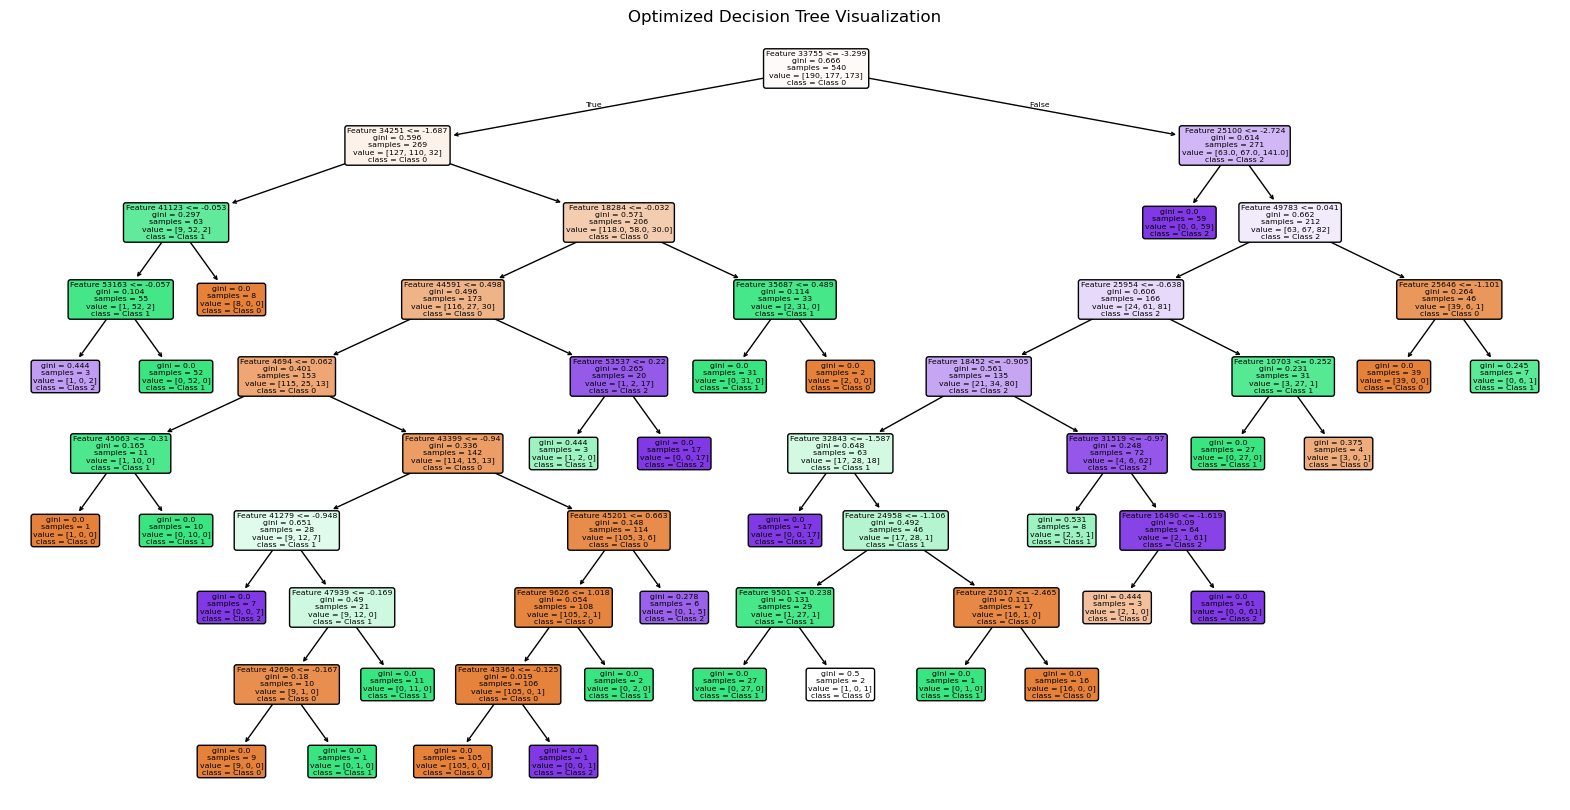

In [70]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Reshape the data for Decision Tree (flatten)
X_train_flat = X_train_scaled.reshape(X_train_scaled.shape[0], -1)
X_test_flat = X_test_scaled.reshape(X_test_scaled.shape[0], -1)
y_train_flat = np.argmax(y_train_3, axis=1)  
y_test_flat = np.argmax(y_test_3, axis=1)

# Hyperparameter tuning
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), 
                           param_grid, 
                           cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train_flat, y_train_flat)

# Best Decision Tree model
best_dt_model = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)

# Predict and evaluate
y_pred_best = best_dt_model.predict(X_test_flat)
print("Classification Report for Optimized Decision Tree:")
print(classification_report(y_test_flat, y_pred_best))
print(f"Optimized Accuracy: {accuracy_score(y_test_flat, y_pred_best):.2f}")

# Visualize the Decision Tree
plt.figure(figsize=(20, 10))
plt.figure(figsize=(20, 10))
plot_tree(best_dt_model, 
          max_depth=3,  
          filled=True, 
          feature_names=[f"Feature {i}" for i in range(X_train_flat.shape[1])],
          class_names=["Class 0", "Class 1", "Class 2"],
          rounded=True)
plt.title("Optimized Decision Tree Visualization")
plt.show()



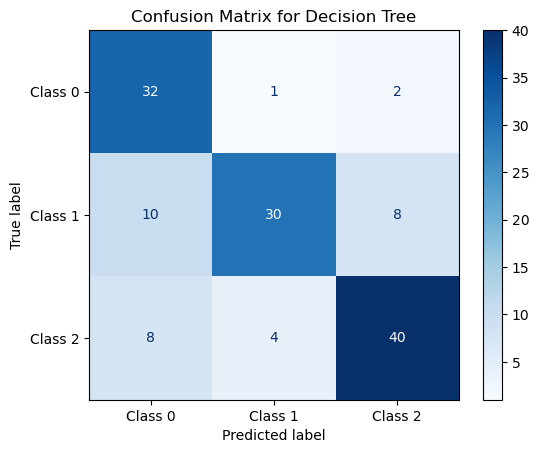

In [79]:
# Predict on the test set
y_pred_best = best_dt_model.predict(X_test_flat)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test_flat, y_pred_best)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Class 0", "Class 1", "Class 2"])
disp.plot(cmap=plt.cm.Blues)  # 设置颜色风格
plt.title("Confusion Matrix for Decision Tree")
plt.show()


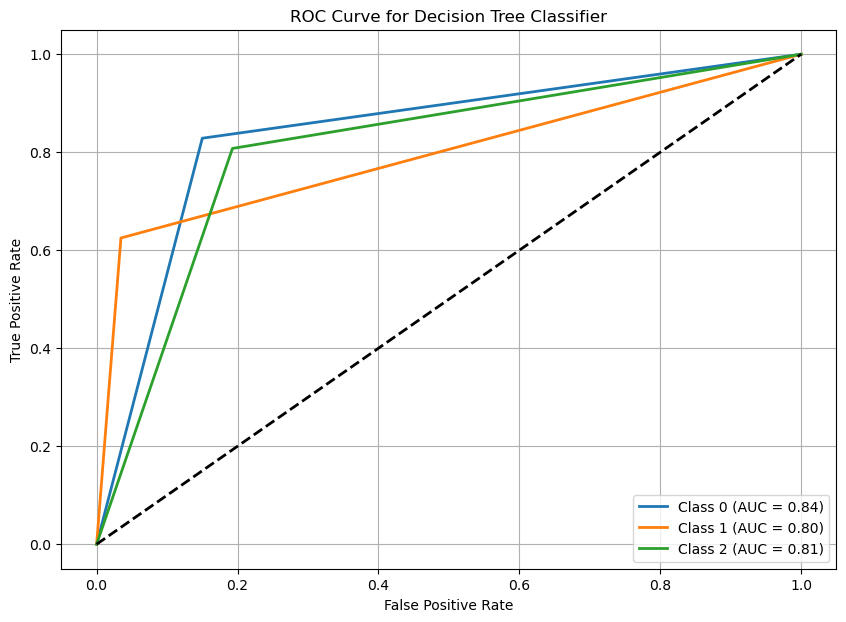

In [81]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize the labels for multi-class ROC (One-vs-Rest approach)
y_test_bin = label_binarize(y_test_flat, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]  # Number of classes

# Get predicted probabilities for each class
y_score = dt_model.predict_proba(X_test_flat)

# Plot ROC curve for each class
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Class {i} (AUC = {roc_auc:.2f})")

# Add diagonal line for random guessing
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Set labels and legend
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Decision Tree Classifier")
plt.legend(loc="lower right")
plt.grid()
plt.show()


**2.4 CNN**

In [100]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Reshape data for CNN
X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], -1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], -1)

# CNN Model
cnn_model = Sequential([
    Input(shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])),  # Input layer
    Conv1D(32, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(3, activation='softmax')  
])


# Compile CNN model
cnn_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# EarlyStopping and ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train CNN model
history_cnn = cnn_model.fit(X_train_cnn, y_train_3, 
                            validation_data=(X_test_cnn, y_test_3),
                            epochs=30, 
                            batch_size=32, 
                            callbacks=[early_stopping, reduce_lr],
                            verbose=1)



Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3959 - loss: 2.5326 - val_accuracy: 0.4148 - val_loss: 2.2493 - learning_rate: 0.0010
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4859 - loss: 1.2720 - val_accuracy: 0.4222 - val_loss: 1.7894 - learning_rate: 0.0010
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5389 - loss: 1.0675 - val_accuracy: 0.4370 - val_loss: 1.2070 - learning_rate: 0.0010
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5873 - loss: 0.8869 - val_accuracy: 0.6000 - val_loss: 0.7994 - learning_rate: 0.0010
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6496 - loss: 0.8436 - val_accuracy: 0.6444 - val_loss: 0.6993 - learning_rate: 0.0010
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6272 - loss: 0.7562 - val_accuracy: 0.7556 - val_loss: 0.6051 - learning_rate: 0.0010
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6554 - loss: 0.6679 - val_acc

<Figure size 800x600 with 0 Axes>

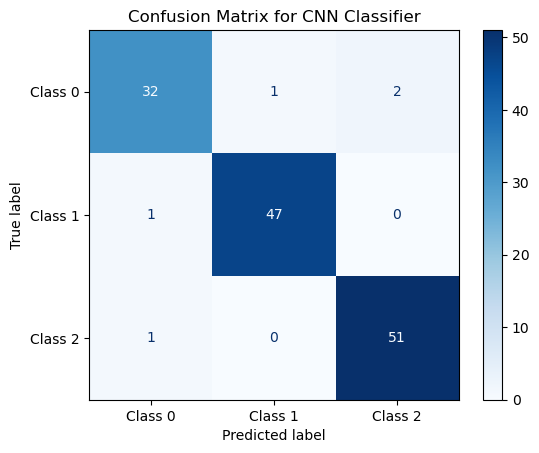

In [104]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes_cnn)

# Define class labels for better visualization
class_labels = ["Class 0", "Class 1", "Class 2"]

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Confusion Matrix for CNN Classifier")
plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Classification Report for CNN:
              precision    recall  f1-score   support

           0       0.94      0.91      0.93        35
           1       0.98      0.98      0.98        48
           2       0.96      0.98      0.97        52

    accuracy                           0.96       135
   macro avg       0.96      0.96      0.96       135
weighted avg       0.96      0.96      0.96       135

Accuracy: 0.96


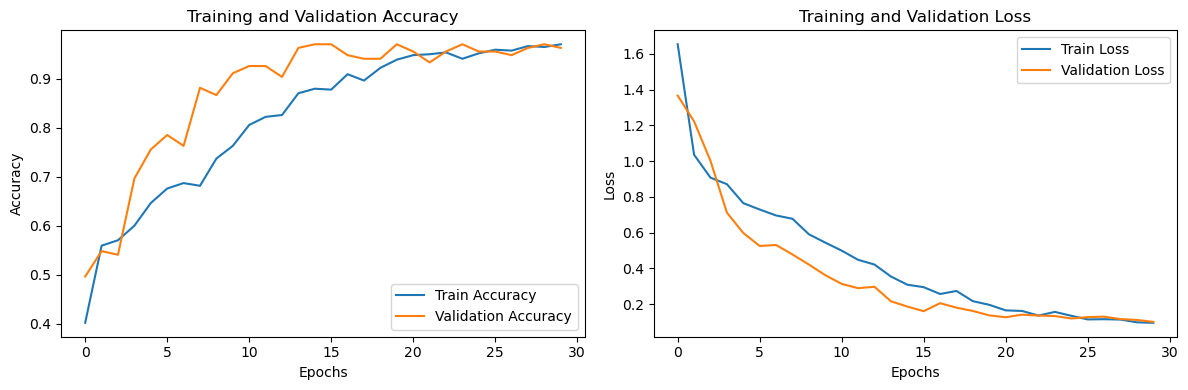

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [98]:
# Evaluate CNN model
y_pred_cnn = cnn_model.predict(X_test_cnn)
y_pred_classes_cnn = np.argmax(y_pred_cnn, axis=1)
y_true_classes = np.argmax(y_test_3, axis=1)

# Print Classification Report
print("Classification Report for CNN:")
print(classification_report(y_true_classes, y_pred_classes_cnn))
print(f"Accuracy: {accuracy_score(y_true_classes, y_pred_classes_cnn):.2f}")

# Visualize Accuracy and Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Plot Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes_cnn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1", "Class 2"])
plt.figure(figsize=(8, 6))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


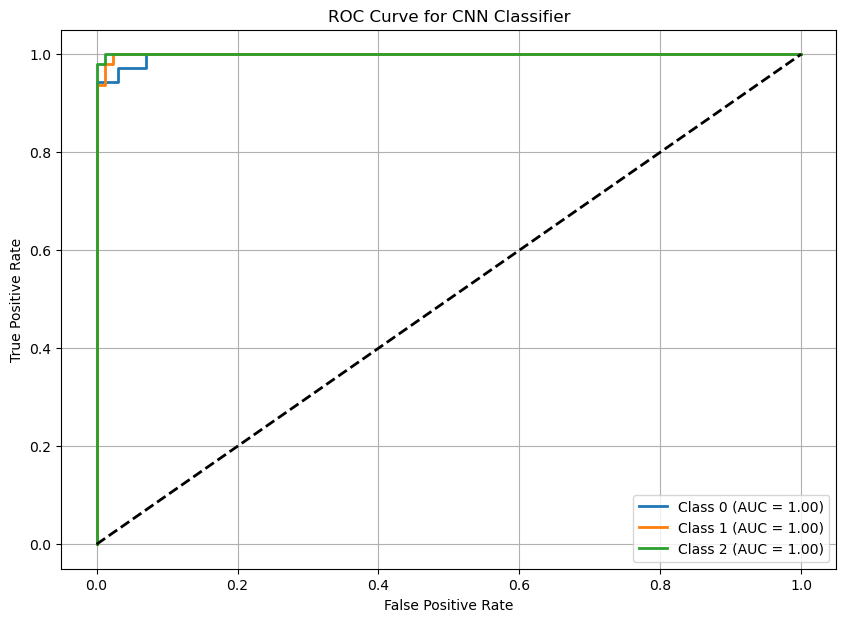

In [102]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize the labels for multi-class ROC
n_classes = y_test_3.shape[1]  # Number of classes
y_test_bin = label_binarize(np.argmax(y_test_3, axis=1), classes=[0, 1, 2])

# Get predicted probabilities for each class
y_score = cnn_model.predict(X_test_cnn)

# Plot ROC curve for each class
plt.figure(figsize=(10, 7))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Class {i} (AUC = {roc_auc:.2f})")

# Add diagonal line for random guessing
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Add labels and title
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for CNN Classifier")
plt.legend(loc="lower right")
plt.grid()
plt.show()


## 3.Music recommendation

In [395]:
pip install playsound

  Preparing metadata (setup.py) ... done
  Created wheel for playsound: filename=playsound-1.3.0-py3-none-any.whl size=7020 sha256=108b4a0d6ce4077b4d209886297b376edcea9946cd22a66358744e0540085ff7
  Stored in directory: /Users/peinuoyi/Library/Caches/pip/wheels/cf/42/ff/7c587bae55eec67b909ca316b250d9b4daedbf272a3cbeb907
Successfully built playsound
Note: you may need to restart the kernel to use updated packages.


**check delay**

In [113]:
from tensorflow.keras.models import load_model
import numpy as np
from playsound import playsound  
import os
import random
import time 

# Path to the music directory
music_dir = os.path.expanduser("~/595/music")

# Use LSTM model to make predictions
y_pred_prob = lstm_model.predict(X_test_reshaped)  # Predicted probabilities
y_pred_classes = np.argmax(y_pred_prob, axis=1)    # Convert to predicted class labels

# Play corresponding music based on predicted emotion and measure delay
def play_music_with_delay(predicted_class):
    """
    Play a random music file from the folder corresponding to the predicted class
    and measure playback delay.
    """
    folder_dict = {
        0: os.path.join(music_dir, "happy"),  # Class 0: happy
        1: os.path.join(music_dir, "calm"),   # Class 1: calm
        2: os.path.join(music_dir, "sad")     # Class 2: sad
    }
    
    folder_path = folder_dict.get(predicted_class, None)
    if folder_path and os.path.exists(folder_path):
        # List all mp3 files in the folder
        music_files = [f for f in os.listdir(folder_path) if f.endswith('.mp3')]
        if music_files:
            # Choose a random file to play
            selected_music = random.choice(music_files)
            music_path = os.path.join(folder_path, selected_music)
            
            # Measure playback delay
            print("Preparing to play music...")
            prepare_time = time.time()  # Time before playback starts
            print("Starting music playback...")
            start_time = time.time()  # Time when playsound is triggered
            
            playsound(music_path)  # Play music
            
            # Calculate and display delays
            loading_delay = start_time - prepare_time  # Time before playback starts
            print(f"Playing music for class {predicted_class}: {music_path}")
            print(f"Time taken to start music playback: {loading_delay:.4f} seconds")
        else:
            print(f"No music files found in folder: {folder_path}")
    else:
        print(f"Folder not found: {folder_path}")

# Demo - Play music for the first test sample and measure delay
sample_index = 0
predicted_class = y_pred_classes[sample_index]
print(f"Predicted class for sample {sample_index}: Class {predicted_class}")
play_music_with_delay(predicted_class)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Predicted class for sample 0: Class 2
Preparing to play music...
Starting music playback...
Playing music for class 2: /Users/peinuoyi/595/music/sad/1-800-273-8255 - Converted with FlexClip.mp3
Time taken to start music playback: 0.0000 seconds
